[View in Colaboratory](https://colab.research.google.com/github/skyho31/revine_cnn/blob/master/vgg4_0_01_0_0005.ipynb)

In [1]:
#@title
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80 chainer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcusparse8.0 is already the newest version (8.0.61-1).
libnvrtc8.0 is already the newest version (8.0.61-1).
libnvtoolsext1 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


# Step 1 - import module

In [2]:
# coding: utf-8
import pickle
import cupy as cp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import sys

# Step 2 - define functions

In [3]:

# define def
def identify_function(x):
    return x

def step_function(x):
    return cp.array(x > 0, dtype=cp.int)

def sigmoid(x):
    return 1 / (1 + cp.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return cp.maximum(0, x)

def relu_grad(x):
    grad = cp.zeros(x)
    grad[x>=0] = 1
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - cp.max(x, axis=0)
        y = cp.exp(x) / cp.sum(cp.exp(x), axis=0)
        return y.T 

    x = x - cp.max(x) # 오버플로 대책
    return cp.exp(x) / cp.sum(cp.exp(x))

def mean_squared_error(y, t):
    return 0.5 * cp.sum((y-t)**2)

# def cross_entropy_error(y, t):
#     delta = 1e-7
#     return -1 * cp.sum(t * cp.log(y + delta))
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -cp.sum(cp.log(y[cp.arange(batch_size), t] + 1e-7)) / batch_size
    
def softmax_loss(x,t):
    y = softmax(x)
    return cross_entropy_error(y, t)

def im2col(icput_data, filter_h, filter_w, stride=1, pad=0):

    N, C, H, W = icput_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = cp.pad(icput_data, [(0,0), (0,0), (pad, pad), (pad,pad)], 'constant')
    col = cp.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, icput_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = icput_shape
    out_h = (H + 2*pad - filter_h)//stride+1
    out_w = (W + 2*pad - filter_w)//stride+1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0,3,4,5,1,2)

    img = cp.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride -1))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] = col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

def numerical_gradient(f, x):
    h = 1e-4
    grad = cp.zeros_like(x)

    it = cp.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val
        it.iternext()

    return grad

# Step 3 - define optimizer
adam

In [4]:
# define optimizer
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = cp.zeros_like(val)
                self.v[key] = cp.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * cp.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (cp.sqrt(self.v[key]) + 1e-8)

# Step 4 - define trainer

In [5]:
# define trainer
class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='adam', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []
        
        # custom
        self.start_time = time.time()

    def train_step(self, i, max_iter):
#         start_time_each = time.time()
           
        batch_mask = cp.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
#         if self.verbose:
#             end_time_each = time.time() - start_time_each
#             infoStr = '=== max_iter:' + str(max_iter) + ' / ' +str(round(i/max_iter*100, 2)) + '%' + '       '  + 'train loss:' + str(loss) +'         time:' + str(int(end_time_each)) + ' seconds' 
#             print(infoStr)
          
        
        if self.current_iter % self.iter_per_epoch == 0:  
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample, self.batch_size)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample, self.batch_size)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose:
              end_time = time.time() - self.start_time
              print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + ', train loss:' + str(loss) + ", time :" + str(int(end_time)) + ' seconds  ===')
                
              self.start_time = time.time()
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step(i, self.max_iter)
         
        test_acc = self.network.accuracy(self.x_test, self.t_test, self.batch_size)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

# step 5 - define layer
relu, convolution, pooling, affine

In [6]:
# define layer
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx
      
class LeakyRelu:
    def __init__(self, alpha=0.3):
        self.mask = None
        self.alpha = alpha
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = out[self.mask] * self.alpha
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = dout[self.mask] * self.alpha
        dx = dout
        
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None

        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape # 텐서 대책이란?
        x = x.reshape(x.shape[0], -1) # reshape에서 -1의 의미는?
        self.x = x

        out = cp.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = cp.dot(dout, self.W.T)
        self.dW = cp.dot(self.x.T, dout)
        self.db = cp.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape) #입력 데이터 모양 변경 이유? 텐서 대응 how?
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[cp.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # for backward
        self.x = None
        self.col = None
        self.col_W = None

        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = cp.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = cp.sum(dout, axis=0)
        self.dW = cp.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = cp.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = cp.argmax(col, axis=1)
        out = cp.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = cp.zeros((dout.size, pool_size))
        dmax[cp.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx
      
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = cp.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask
    
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.icput_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.icput_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.icput_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = cp.zeros(D)
            self.running_var = cp.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = cp.mean(xc**2, axis=0)
            std = cp.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((cp.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.icput_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = cp.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -cp.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = cp.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

# Step 6 - define PPNet

In [7]:
class PPNet:
    """
      conv - relu - conv - relu - batch - dropout
      conv - relu - conv - relu - pooling - dropout
      conv - relu - conv - relu - batch - dropout
      conv - relu - conv - relu - conv - relu - pooling - 
      affine - leakyrelu - batch - dropout -
      affine - leakyrelu - batch - dropout -
      affine - softmax
    """
  
  
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param_1={'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2={'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3={'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4={'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_5={'filter_num':128, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6={'filter_num':128, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_7={'filter_num':256, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_8={'filter_num':256, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_9={'filter_num':256, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=256, output_size=10, weight_init_std=0.01, 
                 use_dropout=True, use_batchnorm=True):
      
        # 가중치 초기화
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm
        
        conv_output_1 = (input_dim[1] - conv_param_1['filter_size'] + 2*conv_param_1['pad']) / conv_param_1['stride'] + 1
        conv_output_2 = (conv_output_1 - conv_param_2['filter_size'] + 2*conv_param_2['pad']) / conv_param_2['stride'] + 1
        conv_output_3 = (conv_output_2 - conv_param_3['filter_size'] + 2*conv_param_3['pad']) / conv_param_3['stride'] + 1
        conv_output_4 = (conv_output_3 - conv_param_4['filter_size'] + 2*conv_param_4['pad']) / conv_param_4['stride'] + 1
        pool_output_1 = conv_output_4 / 2
        
        conv_output_5 = (pool_output_1 - conv_param_5['filter_size'] + 2*conv_param_5['pad']) / conv_param_5['stride'] + 1
        conv_output_6 = (conv_output_5 - conv_param_6['filter_size'] + 2*conv_param_6['pad']) / conv_param_6['stride'] + 1
        conv_output_7 = (conv_output_6 - conv_param_7['filter_size'] + 2*conv_param_7['pad']) / conv_param_7['stride'] + 1
        conv_output_8 = (conv_output_7 - conv_param_8['filter_size'] + 2*conv_param_8['pad']) / conv_param_8['stride'] + 1
        conv_output_9 = (conv_output_8 - conv_param_9['filter_size'] + 2*conv_param_9['pad']) / conv_param_9['stride'] + 1
        
        pool_output_2 = conv_output_9 / 2
                
        pre_node_nums = [
            input_dim[0] * conv_param_1['filter_size'] * conv_param_1['filter_size'],
            conv_param_1['filter_num'] * conv_param_2['filter_size'] * conv_param_2['filter_size'],
            conv_param_2['filter_num'] * conv_param_3['filter_size'] * conv_param_3['filter_size'],
            conv_param_3['filter_num'] * conv_param_4['filter_size'] * conv_param_4['filter_size'],
            conv_param_4['filter_num'] * conv_param_5['filter_size'] * conv_param_5['filter_size'],
            conv_param_5['filter_num'] * conv_param_6['filter_size'] * conv_param_6['filter_size'],
            conv_param_6['filter_num'] * conv_param_7['filter_size'] * conv_param_7['filter_size'],
            conv_param_7['filter_num'] * conv_param_8['filter_size'] * conv_param_8['filter_size'],
            conv_param_8['filter_num'] * conv_param_9['filter_size'] * conv_param_9['filter_size'],
            conv_param_9['filter_num'] * int(pool_output_2) * int(pool_output_2),
            hidden_size,
            hidden_size
        ]
        
        if weight_init_std == 'he':
          weight_init_scales = cp.sqrt(2.0 / pre_node_nums) # he 초기값
        else:
          weight_init_scales = cp.full(pre_node_nums[0], weight_init_std)
          
                
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6, conv_param_7, conv_param_8, conv_param_9]):
          if weight_init_std == 'he':
            self.params['W' + str(idx+1)] = weight_init_scales[idx] * cp.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
          else:
            self.params['W' + str(idx+1)] = weight_init_std * cp.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
  
          self.params['b' + str(idx+1)] = cp.zeros(conv_param['filter_num'])
          pre_channel_num = conv_param['filter_num']
        
        self.params['gamma1'] = cp.ones(int(conv_output_2)**2 * conv_param_2['filter_num'])
        self.params['beta1'] = cp.zeros(int(conv_output_2)**2 * conv_param_2['filter_num'])
        self.params['gamma2'] = cp.ones(int(conv_output_6)**2 * conv_param_6['filter_num'])
        self.params['beta2'] = cp.zeros(int(conv_output_6)**2 * conv_param_6['filter_num'])
        self.params['gamma3'] = cp.ones(hidden_size)
        self.params['beta3'] = cp.zeros(hidden_size)
        self.params['gamma4'] = cp.ones(hidden_size)
        self.params['beta4'] = cp.zeros(hidden_size)

        self.params['W10'] = weight_init_scales[4] * cp.random.randn(pre_node_nums[9], hidden_size)
        self.params['b10'] = cp.zeros(hidden_size)
        self.params['W11'] = weight_init_scales[5] * cp.random.randn(hidden_size, hidden_size)
        self.params['b11'] = cp.zeros(hidden_size)
        self.params['W12'] = weight_init_scales[6] * cp.random.randn(hidden_size, output_size)
        self.params['b12'] = cp.zeros(output_size)


        # 계층 생성
        self.layers = []

        self.layers.append(Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad'])) #0
        self.layers.append(Relu()) #1
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad'])) #2
        self.layers.append(Relu()) #3
        self.layers.append(BatchNormalization(self.params['gamma1'], self.params['beta1'])) #4
        self.layers.append(Dropout(0.25)) #5
        
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], conv_param_3['stride'], conv_param_3['pad'])) #6
        self.layers.append(Relu()) #7
        self.layers.append(Convolution(self.params['W4'], self.params['b4'], conv_param_4['stride'], conv_param_4['pad'])) #8
        self.layers.append(Relu()) #9
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2)) #10
        self.layers.append(Dropout(0.25)) #11
        
        self.layers.append(Convolution(self.params['W5'], self.params['b5'], conv_param_3['stride'], conv_param_3['pad'])) #12
        self.layers.append(Relu()) #13
        self.layers.append(Convolution(self.params['W6'], self.params['b6'], conv_param_4['stride'], conv_param_4['pad'])) #14
        self.layers.append(Relu()) #15
        self.layers.append(BatchNormalization(self.params['gamma2'], self.params['beta2'])) #16
        self.layers.append(Dropout(0.25)) #17
        
        self.layers.append(Convolution(self.params['W7'], self.params['b7'], conv_param_3['stride'], conv_param_3['pad'])) #18
        self.layers.append(Relu()) #19
        self.layers.append(Convolution(self.params['W8'], self.params['b8'], conv_param_4['stride'], conv_param_4['pad'])) #20
        self.layers.append(Relu()) #21
        self.layers.append(Convolution(self.params['W9'], self.params['b9'], conv_param_4['stride'], conv_param_4['pad'])) #22
        self.layers.append(Relu()) #23
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2)) #24
        
        self.layers.append(Affine(self.params['W10'], self.params['b10'])) #25
        self.layers.append(LeakyRelu()) # 26
        self.layers.append(BatchNormalization(self.params['gamma3'], self.params['beta3'])) #27
        self.layers.append(Dropout(0.5)) #28
        
        self.layers.append(Affine(self.params['W11'], self.params['b11'])) #29
        self.layers.append(LeakyRelu()) #30
        self.layers.append(BatchNormalization(self.params['gamma4'], self.params['beta4'])) #31
        self.layers.append(Dropout(0.5)) #32
        
        self.layers.append(Affine(self.params['W12'], self.params['b12'])) # 33
        self.last_layer = SoftmaxWithLoss() #34


    def predict(self, x, train_flg=True):
        for layer in self.layers:
          if isinstance(layer, Dropout) | isinstance(layer, BatchNormalization):
            x = layer.forward(x, train_flg)
          else:
            x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=True):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x, train_flg)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = cp.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = cp.argmax(y, axis=1)
            acc += cp.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, '1', 3, 4, 5, 6, 7, 8, 9, 10, '2', 11, '3', 12):
            if type(idx) == int:
                grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
                grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])
            else:
                grads['gamma' + idx] = numerical_gradient(loss_w, self.params['gamma' + idx])
                grads['beta' + idx] = numerical_gradient(loss_w, self.params['beta' + idx])
        
        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
          dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        tmpTuple = (0, 2, 6, 8, 12, 14, 18, 20, 22, 25, 29, 33)
        batchTuple = (4, 16, 27, 31)
                
        for i, layer_idx in enumerate(tmpTuple):
          grads['W' + str(i+1)] = self.layers[layer_idx].dW
          grads['b' + str(i+1)] = self.layers[layer_idx].db
              
        for i, layer_idx in enumerate(batchTuple):
          grads['gamma' + str(i+1)] = self.layers[layer_idx].dgamma
          grads['beta' + str(i+1)] = self.layers[layer_idx].dbeta

        return grads


    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
      
        for i, key in enumerate((0, 2, 6, 8, 12, 14, 18, 20, 22, 25, 29, 33)):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]
            
        for i, key in enumerate((4, 16, 27, 31)):
            self.layers[key].gamma = self.params['W' + str(i+1)]
            self.layers[key].beta = self.params['b' + str(i+1)]

# Step 7 - execute code

In [8]:
# randomSeed
cp.random.seed(9)


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train=cp.expand_dims(x_train,axis=1)
x_test=cp.expand_dims(x_test,axis=1)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
# x_train, t_train = x_train[:500], t_train[:500]
# x_test, t_test = x_test[:100], t_test[:100]

# 0-1로 정규화
x_train = (x_train.astype(cp.float32))/255
x_test = (x_test.astype(cp.float32))/255

# x_train -= 0.5
# x_test -= 0.5

# x_train *= 2.
# x_test *= 2.

x_train = cp.array(x_train)
x_test = cp.array(x_test)
t_train = cp.array(t_train)
t_test = cp.array(t_test)

max_epochs = 50

batch_size = 200
validation_step =  t_train.shape[0] // batch_size

network = PPNet(input_dim=(1, 28, 28), 
                 conv_param_1={'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2={'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3={'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4={'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_5={'filter_num':128, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6={'filter_num':128, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_7={'filter_num':256, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_8={'filter_num':256, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_9={'filter_num':256, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=512, output_size=10, weight_init_std=0.01)              
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=batch_size,
                  optimizer='Adam', optimizer_param={'lr': 0.0005},
                  evaluate_sample_num_per_epoch=validation_step * batch_size)
# 시간 체크
start_time = time.time()
trainer.train()

# 체크 종료
end_time = time.time() - start_time
print("PPNet took for % seconds" % end_time)

# 매개변수 보관
network.save_params("params.pkl")
print("Saved Network Parameters!")

=== epoch:1, train acc:0.16815, test acc:0.167, train loss:2.0588546160168057, time :177 seconds  ===
=== epoch:2, train acc:0.8087, test acc:0.7965, train loss:0.5656254546019953, time :717 seconds  ===
=== epoch:3, train acc:0.80175, test acc:0.7893, train loss:0.5635013000599122, time :717 seconds  ===
=== epoch:4, train acc:0.8576333333333334, test acc:0.8445, train loss:0.5730680120512588, time :717 seconds  ===
=== epoch:5, train acc:0.8308166666666666, test acc:0.8225, train loss:0.4247367577347637, time :717 seconds  ===
=== epoch:6, train acc:0.85415, test acc:0.8432, train loss:0.4014417467332853, time :717 seconds  ===
=== epoch:7, train acc:0.8636166666666667, test acc:0.8489, train loss:0.4276279709251536, time :717 seconds  ===
=== epoch:8, train acc:0.8727166666666667, test acc:0.8589, train loss:0.4096717682297634, time :717 seconds  ===
=== epoch:9, train acc:0.8618166666666667, test acc:0.8507, train loss:0.4103711452699369, time :717 seconds  ===
=== epoch:10, train 

=== epoch:43, train acc:0.9239, test acc:0.8922, train loss:0.22459409484857706, time :717 seconds  ===
=== epoch:44, train acc:0.9336, test acc:0.8973, train loss:0.23345347169093608, time :717 seconds  ===
=== epoch:45, train acc:0.9181333333333334, test acc:0.8922, train loss:0.17192516602466631, time :717 seconds  ===
=== epoch:46, train acc:0.9231166666666667, test acc:0.8963, train loss:0.19709787514757962, time :717 seconds  ===
=== epoch:47, train acc:0.9306333333333333, test acc:0.8988, train loss:0.1703225002025536, time :717 seconds  ===
=== epoch:48, train acc:0.93725, test acc:0.9011, train loss:0.2009393228679209, time :717 seconds  ===
=== epoch:49, train acc:0.9352666666666667, test acc:0.9002, train loss:0.26361224882376993, time :717 seconds  ===
=== epoch:50, train acc:0.9418833333333333, test acc:0.9066, train loss:0.20974055277373854, time :717 seconds  ===
=============== Final Test Accuracy ===============
test acc:0.9006
PPNet took for 35903.88084411621econds
Sa

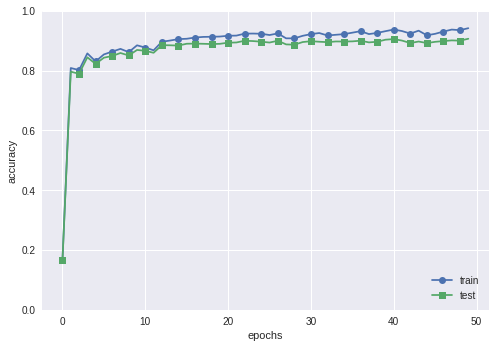

In [9]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()